# Kaggle Batch Challenge


This notebook presents the work that has been done to participate in the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

The notebook is organized and structured in the following way:

- Develop of a **baseline model**
- Improving and refining results with **ensemble methods**
- The problems will be solved through **pipelines**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

In [2]:
# Import neccesary libraries

from scipy import stats

# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

## Load dataset

Dataset details :
- `train.csv` is a (1460 * 81) training set containing `X` and `y`
- `test.csv` is a (1459 * 80) testing set without the associated target `y`!
- `data_description.txt` describing all columns

Your goal is to predict the `y_pred` missing from the test set.

Loading the train dataset in a DataFrame `data` and creating `X` and `y`.

In [3]:
# Loading from S3 bucket
data = pd.read_csv("https://CMoranoA.s3.amazonaws.com/houses_train_raw.csv")
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
X = data.drop(columns=['SalePrice','Id'])
y = data.SalePrice
X.shape

(1460, 79)

# BASELINE

## Initial feature overview

Dividing features based on their `dtype`:

In [5]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

In [6]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()

In [7]:
feat_categorical_nunique.sum()

252

Practically impossible to `OneHotEncode` all categorical features, the feature matrix `X_preproc` would become pretty big and spare, with almost 300 (highly correlated) features for only 1400 observations. Ideally, the model should be fed with with 50-100 features max.

There are 2 main strategies to reduce the number of categorical features post-preprocessing:
- **Remove** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **Ordinally encode** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental. It has to be set properly 

<AxesSubplot:>

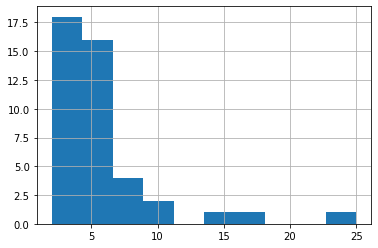

In [8]:
# Plotting histogram of number of variables with categorical features
feat_categorical_nunique.hist()

As a starter, all features that have **7 unique values or more** will be removed, and every others will be one-hot-encoded.

In [9]:
# categorical features to one-hot-encode
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)

In [10]:
len(feat_categorical_small)

34

## Preprocessing pipeline - V1 minimal baseline

---
Coding the basic preprocessing pipeline.

For categorical features
- Simple-Impute with **most frequent values**
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features

As for numerical features
- Simple-Impute with **strategy 'mean'**
- Min-Max Scale 

In [11]:
# Dummy code your pipeline first
# Column Transformer made of 2 pipelines (1 for OHE, 1 for numerical)

preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler())

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, feat_categorical_small),
    remainder="drop")

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17e2fbc40>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [12]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline

(1460, 183)

## Model baseline

Pipping a **basic Ridge regressor** to  `preproc_baseline`.

In [13]:
pipe_baseline = make_pipeline(preproc_baseline, Ridge())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e2fbc40>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder'...
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('ridge', Ridge())])

The Kaggle contest evaluation rules demands Root Mean Squared Log Error as a performance metric. This metric should be created using 'make scorer' of sklearn. Also, there will be created the negative score `rmsle_neg` which is best when _maximized_. This will come handy later as `GridSearchCV` requires a score to _maximize_

In [14]:
# OPTION 1: recoding it all manually

def root_mean_squared_log_error(y_true, y_pred):
    t = np.array(y_true)
    p = np.array(y_pred)
    log_error = np.log(1+t) - np.log(1+p)
    return ((log_error**2).mean())**0.5

# This is the metric to minimize
rmsle = make_scorer(root_mean_squared_log_error)

# This is the score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * root_mean_squared_log_error(y_true, y_pred))

In [15]:
# OPTION 2 - reuse sklearn "mean_squared_log_error"
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

# This is the metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is the score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

# Equivalent formulation
rmsle_neg = make_scorer(
    lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5,
    greater_is_better=False
)

5-fold cross_validate the `pipe_baseline` using this metric to get a first glance at the baseline perf.    

In [16]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

0.16642907520861652

## Predict baseline

Predict `y_pred_baseline` from the Kaggle `test.csv` dataset.

In [17]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

# Predict y_pred_baseline
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline

array([113256.76959388, 136811.0145436 , 174901.68834287, ...,
       157216.07718185, 111472.49591662, 234985.99120322])

Storing the CSV ready to be submitted as `submission_baseline.csv` according to Kaggle required format.

In [18]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)

,Id,SalePrice
0,1461,113256.769594


In [19]:
# Export to Kaggle format submission in the `data` folder
results.to_csv("data/submission_baseline.csv", header=True, index=False)

# ITERATIONS 

This chapter aims to improve the predictions. To accomplish this, the following models will be tried.

**Models**

- Linear Models: fine-tune regularization.
- **Tree-based ensembles**: Probably the best suited for many categorical-features problems
- Stacking.

## Preprocessing Iteration

### Ordinal Encoding

Splitting categorical preprocessor into

- `preproc_ordinal` to ordinally encode **features**
- `preproc_nominal` to one hot encode the other ones

In [20]:
# Defining specific order for features

feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [21]:
# Define numerical feature
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

In [22]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

In [23]:
preproc = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17e357040>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [24]:
preproc.fit_transform(X).shape

(1460, 216)

### Target engineering

As the competition ask to minimize the RMS**L**E, the target variable will be directly transformed to its log.

For interpretation purposes, the results should be exponentiated.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

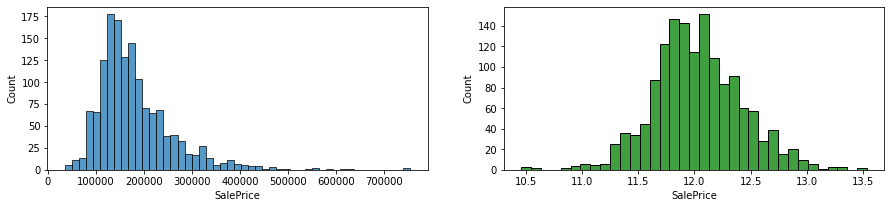

In [25]:
y_log = np.log(y)
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.histplot(y)
plt.subplot(1,2,2)
sns.histplot(y_log, color='green')

In [26]:
# Create  new scorer to minimize
from sklearn.metrics import mean_squared_error
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create  new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

### Statistical Feature Selection

Removing the least interesting features, to limit overfitting and shorten training time.  

- Adding a `SelectPercentile` filter (coupled with `mutual_info_regression` for the statistical test to use) at the end of the `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!  

In [27]:
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only 50% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x180521250>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordi...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x18053b790>))])

In [28]:
preproc.fit_transform(X,y_log).shape

(1460, 108)

Using Pearson's correlation combined with a heatmap...
- to check visually whether some **numerical** features almost entirely explain others. 
- Then filtering the pipeline to remove any correlated below a certain threshold. Avoid collinearity

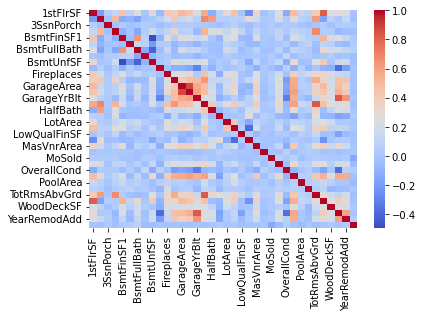

In [29]:
corr_num = X[feat_numerical].corr()
sns.heatmap(corr_num, cmap='coolwarm');

Using Spearman's rank correlation combined with a heatmap...
- to whether some **ordinally encoded** features are almost entirely "ordered" similarily than others
- Then creating a "filter" that removes any ordinal features correlated below a certain threshold

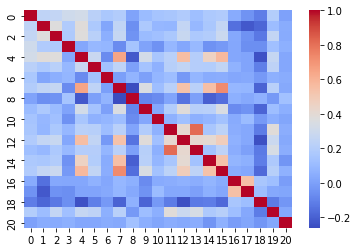

In [30]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]))
sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm');

A extra way to filter out feature relies solely on removing those with the lowest variance.  
- A feature which only takes one value is useless (and has a variance of 0).  
- This is done by adding a `VarianceThreshold` to the end of the pipeline

Text(0.5, 1.0, 'Number of Feature Remaining')

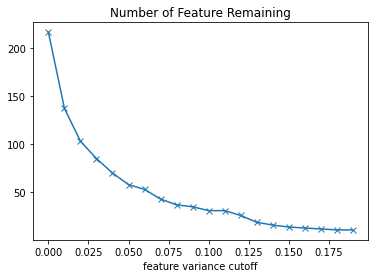

In [31]:
from sklearn.feature_selection import VarianceThreshold

def number_feature_remaining(cutoff=0):
    preproc_transformer = make_column_transformer(
        (preproc_numerical, feat_numerical),
        (preproc_ordinal, feat_ordinal),
        (preproc_nominal, feat_nominal),
        remainder="drop")

    preproc_selector = VarianceThreshold(cutoff)

    preproc = make_pipeline(
        preproc_transformer,
        preproc_selector)

    return preproc.fit_transform(X).shape[1]

cutoff_values = np.arange(0, 0.2, 0.01)
plt.plot(cutoff_values, [number_feature_remaining(t) for t in cutoff_values], marker='x')
plt.xlabel("feature variance cutoff")
plt.title("Number of Feature Remaining")

### Final preproc pipeline

In [32]:
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=75, # keep only 75% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1807b2f70>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordi...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=75,
                                  score_func=<function mutual_info_regression at 0x18053b790>))])

In [33]:
# Checking shape
preproc_fitted = preproc.fit(X,y)
preproc_fitted_log = preproc.fit(X,y_log)
preproc_fitted_log.transform(X).shape

(1460, 162)

## Models Iteration

In [34]:
allow_grid_searching = False # use True to activate girdsearch

### KNN

In [35]:
model = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc, model)

In [36]:
scores = cross_val_score(pipe_knn, X, y_log, cv=5, scoring=rmse)
scores.mean()

0.20544669466128546

In [37]:
# GridSearch the KNN

param_grid =  {'kneighborsregressor__n_neighbors': [3,4,5,6,7,8,9,10,15,20,30]}
search_knn = GridSearchCV(pipe_knn, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=1, scoring=rmse_neg)

search_knn.fit(X, y_log);
print(search_knn.best_params_)
print(search_knn.best_score_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
{'kneighborsregressor__n_neighbors': 6}
-0.20749348951416727


### SVM

In [38]:
model = SVR(kernel='linear')
pipe_svm = make_pipeline(preproc, model)
cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()

0.13950726144720768

In [39]:
model = SVR(kernel='rbf', C = 10)
pipe_svm_rbf = make_pipeline(preproc, model)
cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()

0.13386528060402783

In [40]:
# GridSearch the SVM

param_grid =  {'svr__C': [0.5, 0.7, 1, 2, 5, 10],
              'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5]}

search_svm_rbf = GridSearchCV(pipe_svm_rbf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=1, scoring=rmse_neg)

search_svm_rbf.fit(X, y_log);
svm_rbf_best = search_svm_rbf.best_estimator_
print(search_svm_rbf.best_params_)
print(search_svm_rbf.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'svr__C': 1, 'svr__epsilon': 0.01}
-0.12498857031837193


### Trees

In [41]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)
pipe_tree = make_pipeline(preproc, model)
score = cross_val_score(pipe_tree, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.01017475047487835


0.18873146932671742

In [42]:
#GridSearchCV
param_tree={"decisiontreeregressor__splitter":["best","random"],
            "decisiontreeregressor__max_depth" : [1,5,10,15,20,30,50]}

search_tree = GridSearchCV(pipe_tree, param_grid=param_tree, cv=5, verbose=1,
                          scoring=rmse_neg)

# Fit data to Grid Search
search_tree.fit(X, y_log);
print(search_tree.best_params_)
search_tree.best_score_

# Plot results of gridsearch
df_tree_cv_results_ = pd.DataFrame(search_tree.cv_results_)
df_tree_cv_results_

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'decisiontreeregressor__max_depth': 15, 'decisiontreeregressor__splitter': 'best'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeregressor__max_depth,param_decisiontreeregressor__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.053167,0.018628,0.013301,0.000858,1,best,"{'decisiontreeregressor__max_depth': 1, 'decis...",-0.284097,-0.304406,-0.299909,-0.285870,-0.292125,-0.293281,0.007853,13
1,1.050265,0.018365,0.013143,0.000766,1,random,"{'decisiontreeregressor__max_depth': 1, 'decis...",-0.320459,-0.340330,-0.338063,-0.285870,-0.304517,-0.317848,0.020597,14
2,1.055027,0.019713,0.013256,0.000400,5,best,"{'decisiontreeregressor__max_depth': 5, 'decis...",-0.185106,-0.198854,-0.194170,-0.182743,-0.207222,-0.193619,0.008984,6
3,1.050915,0.019512,0.013318,0.001030,5,random,"{'decisiontreeregressor__max_depth': 5, 'decis...",-0.187595,-0.216814,-0.223319,-0.211322,-0.204363,-0.208683,0.012253,12
4,1.055258,0.020858,0.013271,0.000519,10,best,"{'decisiontreeregressor__max_depth': 10, 'deci...",-0.183700,-0.197076,-0.182651,-0.176855,-0.203990,-0.188855,0.010057,2
5,1.045097,0.016843,0.013321,0.000625,10,random,"{'decisiontreeregressor__max_depth': 10, 'deci...",-0.183747,-0.214444,-0.212978,-0.182182,-0.203306,-0.199332,0.013910,8
6,1.048180,0.017274,0.013407,0.000444,15,best,"{'decisiontreeregressor__max_depth': 15, 'deci...",-0.183700,-0.197076,-0.182651,-0.176457,-0.203990,-0.188775,0.010153,1
7,1.044317,0.018251,0.013495,0.000247,15,random,"{'decisiontreeregressor__max_depth': 15, 'deci...",-0.180709,-0.215123,-0.216984,-0.208260,-0.200307,-0.204277,0.013162,10
8,1.047669,0.012215,0.013455,0.001229,20,best,"{'decisiontreeregressor__max_depth': 20, 'deci...",-0.183483,-0.197076,-0.183093,-0.176855,-0.203990,-0.188899,0.010027,4
9,1.041716,0.018979,0.013540,0.000516,20,random,"{'decisiontreeregressor__max_depth': 20, 'deci...",-0.202264,-0.210129,-0.212077,-0.199289,-0.198391,-0.204430,0.005631,11


### Random Forest

In [43]:
model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)
pipe_rf = make_pipeline(preproc, model)
score = cross_val_score(pipe_rf, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.008126796393324583


0.1622191226624124

In [44]:
#GridSearchCV
param_rf = { 
            "randomforestregressor__n_estimators": [10,20,30],
            "randomforestregressor__max_features": ["auto", "sqrt", "log2"],
            "randomforestregressor__min_samples_split": [2,4,8],
            "randomforestregressor__bootstrap": [True, False],
            }

search_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=5, verbose=1,
                          scoring=rmse_neg)

# Fit data to Grid Search
search_rf.fit(X, y_log);
print(search_rf.best_params_)
print(search_rf.best_score_)

# Plot results of gridsearch
df_tree_cv_results_ = pd.DataFrame(search_rf.cv_results_)
df_tree_cv_results_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 30}
-0.16262206817185834


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__bootstrap,param_randomforestregressor__max_features,param_randomforestregressor__min_samples_split,param_randomforestregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.090688,0.019857,0.013648,0.000698,True,auto,2,10,"{'randomforestregressor__bootstrap': True, 'ra...",-0.160033,-0.173063,-0.172402,-0.156245,-0.174973,-0.167343,0.007657,12
1,1.136845,0.017867,0.014846,0.000635,True,auto,2,20,"{'randomforestregressor__bootstrap': True, 'ra...",-0.159851,-0.173877,-0.170770,-0.150772,-0.173368,-0.165727,0.009038,7
2,1.189188,0.021543,0.014725,0.000195,True,auto,2,30,"{'randomforestregressor__bootstrap': True, 'ra...",-0.156003,-0.168985,-0.168894,-0.150417,-0.168811,-0.162622,0.007886,1
3,1.085368,0.019662,0.013499,0.000437,True,auto,4,10,"{'randomforestregressor__bootstrap': True, 'ra...",-0.160595,-0.168796,-0.170291,-0.161331,-0.173145,-0.166832,0.004997,9
4,1.135227,0.018058,0.014378,0.000406,True,auto,4,20,"{'randomforestregressor__bootstrap': True, 'ra...",-0.153453,-0.173805,-0.167938,-0.156114,-0.169211,-0.164104,0.007902,5
5,1.184362,0.018886,0.015269,0.000676,True,auto,4,30,"{'randomforestregressor__bootstrap': True, 'ra...",-0.156663,-0.170497,-0.167236,-0.153506,-0.172284,-0.164037,0.007553,4
6,1.086155,0.015934,0.013932,0.000540,True,auto,8,10,"{'randomforestregressor__bootstrap': True, 'ra...",-0.153758,-0.172280,-0.161388,-0.156742,-0.175745,-0.163983,0.008613,3
7,1.134017,0.018700,0.014416,0.000371,True,auto,8,20,"{'randomforestregressor__bootstrap': True, 'ra...",-0.154207,-0.173690,-0.172104,-0.157077,-0.170446,-0.165505,0.008169,6
8,1.190352,0.020965,0.014615,0.000471,True,auto,8,30,"{'randomforestregressor__bootstrap': True, 'ra...",-0.156943,-0.167421,-0.167018,-0.155147,-0.170951,-0.163496,0.006262,2
9,1.045826,0.015652,0.014268,0.000342,True,sqrt,2,10,"{'randomforestregressor__bootstrap': True, 'ra...",-0.163365,-0.192899,-0.194526,-0.176302,-0.184192,-0.182257,0.011488,32


### Boosted Trees

In [45]:
model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=None))

pipe = make_pipeline(preproc, model)
score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.009704991678086557


0.1418589234020551

In [46]:
model = GradientBoostingRegressor(n_estimators=100, verbose=0)
pipe_gb = make_pipeline(preproc, model)
score = cross_val_score(pipe_gb, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.010671713562082174


0.12534282459742718

In [47]:
grid = {
     'gradientboostingregressor__n_estimators': np.arange(50,300, 50),
     'gradientboostingregressor__max_features': np.arange(0.7,1, 0.1), # default None, i.e = n_features
}

search_gb = GridSearchCV(pipe_gb, grid, scoring=rmse_neg, cv=5, n_jobs=1, verbose=1)

# Fit data to Grid Search
search_gb.fit(X, y_log);
print(search_gb.best_params_)
print(search_gb.best_score_)

# Plot results of gridsearch
df_cv_results_ = pd.DataFrame(search_gb.cv_results_)
df_cv_results_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'gradientboostingregressor__max_features': 0.7999999999999999, 'gradientboostingregressor__n_estimators': 250}
-0.12141879823644511


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingregressor__max_features,param_gradientboostingregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.198540,0.014930,0.013750,0.000785,0.7,50,{'gradientboostingregressor__max_features': 0....,-0.119051,-0.148422,-0.138024,-0.126976,-0.132885,-0.133071,0.009939,19
1,1.349362,0.023747,0.013876,0.000565,0.7,100,{'gradientboostingregressor__max_features': 0....,-0.112490,-0.134817,-0.130062,-0.117391,-0.125987,-0.124149,0.008170,12
2,1.496708,0.021928,0.014437,0.000593,0.7,150,{'gradientboostingregressor__max_features': 0....,-0.110363,-0.141038,-0.129507,-0.114707,-0.121774,-0.123478,0.010923,9
3,1.648879,0.023012,0.014306,0.000625,0.7,200,{'gradientboostingregressor__max_features': 0....,-0.110327,-0.137021,-0.130118,-0.111047,-0.128088,-0.123320,0.010734,8
4,1.806685,0.026311,0.014315,0.000409,0.7,250,{'gradientboostingregressor__max_features': 0....,-0.109929,-0.143775,-0.130485,-0.113935,-0.123241,-0.124273,0.012105,14
5,1.214364,0.017700,0.013625,0.000472,0.8,50,{'gradientboostingregressor__max_features': 0....,-0.120223,-0.146842,-0.138708,-0.129954,-0.129452,-0.133036,0.009048,18
6,1.389977,0.014738,0.013706,0.000398,0.8,100,{'gradientboostingregressor__max_features': 0....,-0.113783,-0.134329,-0.134352,-0.115813,-0.122805,-0.124217,0.008791,13
7,1.558507,0.017640,0.014347,0.001377,0.8,150,{'gradientboostingregressor__max_features': 0....,-0.112748,-0.137841,-0.133058,-0.110703,-0.121981,-0.123266,0.010756,7
8,1.732739,0.021554,0.013660,0.000236,0.8,200,{'gradientboostingregressor__max_features': 0....,-0.116046,-0.132937,-0.131887,-0.111592,-0.119976,-0.122488,0.008533,4
9,1.908651,0.017385,0.014529,0.000678,0.8,250,{'gradientboostingregressor__max_features': 0....,-0.114536,-0.134063,-0.130339,-0.110912,-0.117244,-0.121419,0.009107,1


### Stacking

In [49]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))


model = VotingRegressor(
    estimators = [("gboost", gboost),("adaboost", adaboost),("ridge", ridge), ("svm_rbf", svm)],
    weights = [1,1,1,1], # to equally weight the two models
    n_jobs=-1
)

pipe_ensemble = make_pipeline(preproc, model)

score = cross_val_score(pipe_ensemble, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(score.std())
score.mean()

0.012350731352032377


0.11934944574036573

In [62]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

model = StackingRegressor(
    estimators=[("gboost", gboost),("adaboost", adaboost),("ridge", ridge), ("svm_rbf", svm)],
    
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model)
score_stack = cross_val_score(pipe_stacking, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(score_stack.std())
score_stack.mean()

0.011304524824444365


0.11802573987928863

### XGBOOST

In [52]:
from xgboost import XGBRegressor

In [53]:
# Creating eval test just for early stopping purpose (XGBOOST and Deep Learning)
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X,y_log,random_state=42)

In [54]:
# Instanciate model
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.05)

In [63]:
# Option 1: Integrate XGB into Sklearn's pipeline
# It allows to GridSearchCV its best hyperparams
pipe_xgb = make_pipeline(preproc, model_xgb)
score_xgb = cross_val_score(pipe_xgb, X, y_log, cv=5, scoring=rmse, n_jobs=-1).mean()
score_xgb.mean()

0.12987828055517428

### Compare results

In [71]:
final_results_dict ={'KNN': search_knn.best_score_ * -1,
                             'SVM': search_svm_rbf.best_score_ * -1,
                             'D_Tree': search_tree.best_score_ * -1,
                             'Random_Forest': search_rf.best_score_ * -1,
                             'Gradient_Boost': search_gb.best_score_ * -1,
                             'Stacking': score_stack.mean(),
                             'XGBoost': score_xgb.mean()}

final_results_dict

{'KNN': 0.20749348951416727,
 'SVM': 0.12498857031837193,
 'D_Tree': 0.1887748341511152,
 'Random_Forest': 0.16262206817185834,
 'Gradient_Boost': 0.12141879823644511,
 'Stacking': 0.11802573987928863,
 'XGBoost': 0.12987828055517428}

In [77]:
final_results = pd.DataFrame.from_dict(final_results_dict, orient ='index', columns = ['RMSE'])
final_results

,RMSE
KNN,0.207493
SVM,0.124989
D_Tree,0.188775
Random_Forest,0.162622
Gradient_Boost,0.121419
Stacking,0.118026
XGBoost,0.129878


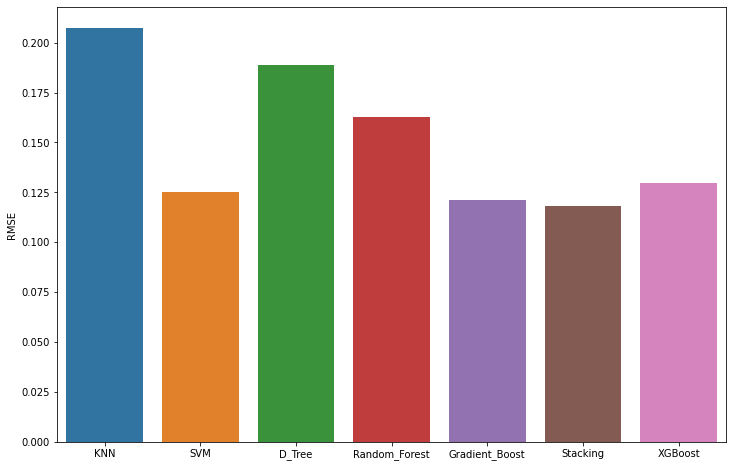

In [91]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x = final_results.index, y = final_results['RMSE'], data=final_results)